# Problem 3: Mix some probability models

# Conclusions:
- A pretty siginifcant 7\% contribution comes from the probability n-gram model
- Loss reduced to 2.11 (val) and 2.14 (test) for context window 3 models

In [1]:
with open("../names.txt", 'r') as file:
    names = file.read().splitlines()

len(names)

32033

In [2]:
chars = sorted(list(set("".join(name for name in names))))
stoi, itos = {}, {}

stoi['.'] = 0
itos[0] = '.'

for i, ch in enumerate(chars):
    stoi[ch] = i + 1
    itos[i + 1] = ch

len(stoi), len(itos)

(27, 27)

In [4]:
btoi, itob = {}, {}

n = 0
for ch1 in (chars + ['.']):
    for ch2 in (chars + ['.']):
        bigram = ch1 + ch2
        btoi[bigram] = n
        itob[n] = bigram
        n += 1

len(btoi), len(itob)

(729, 729)

In [3]:
from sklearn.model_selection import train_test_split  

random_state = 42
names_train, names_temp = train_test_split(names, test_size=0.2, random_state=random_state,\
                                            shuffle=True)  
names_dev, names_test = train_test_split(names_temp, test_size=0.5, random_state=random_state,\
                                            shuffle=True)  

len(names_train), len(names_dev), len(names_test)

(25626, 3203, 3204)

In [56]:
import torch

def create_dataset(names, window_size=3):
    xs, ys = [], []

    for name in names:
        # print(name)
        name = ['.'] * window_size + list(name) + ['.']
        for i, ch in enumerate(name[window_size:]):
            x = [stoi[c] for c in name[i:i + window_size]]
            y = stoi[ch]
            # print(f"{x}-->{y}")
            xs.append(x)
            ys.append(y)

    xs = torch.Tensor(xs).long()
    ys = torch.Tensor(ys).long()

    return xs, ys

def create_unigram_probs(names):
    counts = torch.ones((len(stoi), )).float() # smoothening term

    for name in names:
        name = ['.'] + list(name) + ['.']

        for ch in name:
            i = stoi[ch]
            counts[i] += 1

    probs = counts / counts.sum(dim = 0)

    return probs

def create_bigram_probs(names):
    counts = torch.ones((len(stoi), len(stoi))).float() # smoothening term

    for name in names:
        name = ['.'] + list(name) + ['.']

        for ch1, ch2 in zip(name, name[1:]):
            i1, i2 = stoi[ch1], stoi[ch2]
            counts[i1][i2] += 1

    probs = counts / counts.sum(dim=1, keepdim=True)
    return probs

def create_trigram_probs(names):
    counts = torch.ones((len(stoi), len(stoi), len(stoi))).float() # smoothening term

    for name in names:
        name = ['.'] + list(name) + ['.']

        for ch1, ch2, ch3 in zip(name, name[1:], name[2:]):
            i1, i2, i3 = stoi[ch1], stoi[ch2], stoi[ch3]
            counts[i1][i2][i3] += 1

    probs = counts / counts.sum(dim=2, keepdim=True)
    return probs

In [57]:
X_train, y_train = create_dataset(names_train)
X_dev, y_dev = create_dataset(names_dev)
X_test, y_test = create_dataset(names_test)
X_train.shape, y_train.shape, X_dev.shape, y_dev.shape, X_test.shape, y_test.shape

(torch.Size([182497, 3]),
 torch.Size([182497]),
 torch.Size([22882, 3]),
 torch.Size([22882]),
 torch.Size([22767, 3]),
 torch.Size([22767]))

In [58]:
unigram_prob = create_unigram_probs(names_train)
bigram_prob = create_bigram_probs(names_train)
trigram_prob = create_trigram_probs(names_train)
unigram_prob.shape, bigram_prob.shape, trigram_prob.shape

(torch.Size([27]), torch.Size([27, 27]), torch.Size([27, 27, 27]))

In [59]:
unigram_prob.sum()

tensor(1.0000)

In [60]:
bigram_prob[16].sum()

tensor(1.0000)

In [ ]:
trigram_prob[6, 1].sum()

tensor(1.0000)

## Create the model , forward and training loop

In [66]:
def create_model(emb_dim, hidden_size, window_size, vocab_size, direct=False, num_prob_models=2):
    g = torch.Generator().manual_seed(2147483647)

    # Using paper vocab
    C = torch.randn((vocab_size, emb_dim), dtype=torch.float32,\
                     generator=g, requires_grad=True)
    
    H = torch.randn((emb_dim * window_size, hidden_size), dtype=torch.float32,\
                     generator=g, requires_grad=True)
    d = torch.randn(hidden_size, dtype=torch.float32, generator=g, requires_grad=True)

    U = torch.randn((hidden_size, vocab_size), dtype=torch.float32, generator=g,\
                     requires_grad=True)
    b = torch.randn(vocab_size, dtype=torch.float32, generator=g, requires_grad=True)

    params = [C, H, d, U, b]

    if direct:
        W = torch.randn((emb_dim * window_size, vocab_size), dtype=torch.float32,\
                     generator=g, requires_grad=True)
        params.append(W)

    return params

In [67]:
def forward(batch, params, direct=False):
    if direct:
        C, H, d, U, b, W = params
    else:
        C, H, d, U, b = params

    inp = C[batch].view((batch.shape[0], -1))
    h = torch.tanh(inp @ H + d)
    logits = h @ U + b

    if direct:
        logits += inp @ W

    return logits

In [68]:
import torch.nn.functional as F

def train(params, X, y, epochs, batch_size, lr_scheduler, direct=False):
    g = torch.Generator().manual_seed(2147483647)
    stepi, lossi = [], []

    for epoch in range(epochs):
        # set grads as None
        for p in params:
            p.grad = None

        # create minibatch
        ix = torch.randint(0, len(X), (batch_size, ), generator=g)
        batch = X[ix]

        # return batch

        # forward
        logits = forward(batch, params, direct)

        # loss compute
        nll = F.cross_entropy(logits, y[ix])

        # backward
        nll.backward()

        # update params
        for p in params:
            p.data -= lr_scheduler(epoch) * p.grad

        stepi.append(epoch)
        lossi.append(nll.log10().item())

    return stepi, lossi


In [69]:
params_direct_true = create_model(emb_dim=10, hidden_size=400, window_size=3,\
                                 vocab_size=len(stoi), direct=True)
stepi, lossi = train(params_direct_true, X_train, y_train, epochs=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)),\
                            direct=True)

In [70]:
def get_loss(params, X, y, direct=False):
    logits = forward(X, params, direct)
    nll = F.cross_entropy(logits, y)

    return nll.item()    

In [71]:
train_loss = get_loss(params_direct_true, X_train, y_train, direct=True)
dev_loss = get_loss(params_direct_true, X_dev, y_dev, direct=True)
train_loss, dev_loss

(2.0785534381866455, 2.131584644317627)

In [131]:
test_loss = get_loss(params_direct_true, X_test, y_test, direct=True)
test_loss

2.1577773094177246

## Now train to learn combining probs

In [73]:
for p in params_direct_true:
    p.requires_grad = False

In [141]:
def forward_combine(params, X, y, unigram_prob, bigram_prob, trigram_prob, probW, batch_size, lr_scheduler, epochs, direct=True):
    g = torch.Generator().manual_seed(2147483647)
    stepi, lossi = [], []

    for epoch in range(epochs):
        # set grads as None
        probW.grad = None

        combineProbW = torch.softmax(probW, dim=0)

        # create minibatch
        ix = torch.randint(0, len(X), (batch_size, ), generator=g)
        batch = X[ix]

        # forward
        logitsNN = forward(batch, params, direct)
        probsNN = torch.softmax(logitsNN, dim=1)
        probsUnigram = unigram_prob.view(1, -1).expand(batch_size, -1) 
        probsBigram = bigram_prob[batch[:,-1]]
        probsTrigram = trigram_prob[batch[:,-2], batch[:,-1], :]

        allProbs = torch.stack([probsNN, probsUnigram, probsBigram, probsTrigram], dim=2)
        combineProbs = allProbs @ combineProbW
        
        # Loss and backward
        loss = -torch.log(combineProbs[torch.arange(batch_size), y[ix]]).mean()  

        loss.backward()

        # Update params
        probW.data -= lr_scheduler(epoch) * probW.grad

        stepi.append(epoch)
        lossi.append(loss.log10().item())

    return stepi, lossi


In [154]:
g = torch.Generator().manual_seed(2147483647)

probW = torch.randn((4,), dtype=torch.float32, generator=g, requires_grad=True)

In [155]:

stepi, lossi = forward_combine(params_direct_true, X_train, y_train,\
                 unigram_prob, bigram_prob, trigram_prob,\
                      probW, batch_size=128, lr_scheduler=lambda i: 10**(-0.5) if i<10000 else 10**(-1.5),\
                           epochs=20000, direct=True)

In [156]:
import matplotlib.pyplot as plt
%matplotlib inline

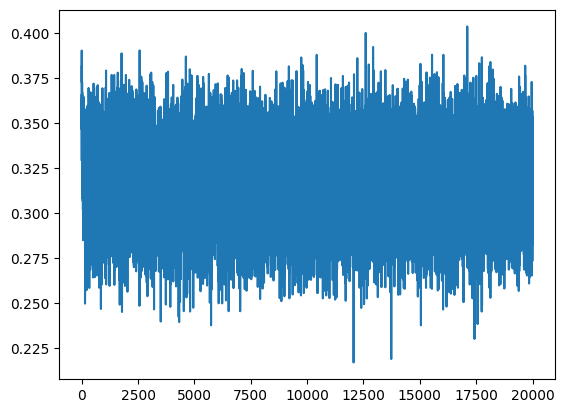

In [157]:
plt.plot(stepi, lossi)


In [158]:
def get_combine_loss(params, X, y, unigram_prob, bigram_prob, trigram_prob, probW, direct=False):
    combineProbW = torch.softmax(probW, dim=0)

    logitsNN = forward(X, params, direct)
    probsNN = torch.softmax(logitsNN, dim=1)
    probsUnigram = unigram_prob.view(1, -1).expand(X.shape[0], -1) 
    probsBigram = bigram_prob[X[:,-1]]
    probsTrigram = trigram_prob[X[:,-2], X[:,-1], :]

    allProbs = torch.stack([probsNN, probsUnigram, probsBigram, probsTrigram], dim=2)
    combineProbs = allProbs @ combineProbW

    loss = -torch.log(combineProbs[torch.arange(X.shape[0]), y]).mean()
    return loss.item()    

In [159]:
train_loss = get_combine_loss(params_direct_true, X_train, y_train,\
                               unigram_prob, bigram_prob, trigram_prob, probW, direct=True)
dev_loss = get_combine_loss(params_direct_true, X_dev, y_dev,\
                             unigram_prob, bigram_prob, trigram_prob, probW, direct=True)
train_loss, dev_loss

(2.0730061531066895, 2.117849111557007)

In [160]:
test_loss = get_combine_loss(params_direct_true, X_test, y_test,\
                             unigram_prob, bigram_prob, trigram_prob, probW, direct=True)
test_loss

2.1390018463134766

In [162]:
combineProbW = probW.softmax(dim=0)

In [163]:
combineProbW

tensor([9.2110e-01, 9.0479e-04, 2.3024e-03, 7.5692e-02],
       grad_fn=<SoftmaxBackward0>)

In [164]:
combineProbW[0]

tensor(0.9211, grad_fn=<SelectBackward0>)

In [165]:
combineProbW[1]

tensor(0.0009, grad_fn=<SelectBackward0>)

In [166]:
combineProbW[2]

tensor(0.0023, grad_fn=<SelectBackward0>)

In [167]:
combineProbW[3]

tensor(0.0757, grad_fn=<SelectBackward0>)

## Sampling

In [171]:
g = torch.Generator().manual_seed(2147483647 + 1)

for i in range(20):
    curr_window, curr_name = ['.'] * 3, ""

    while True:
        ix = [stoi[ch] for ch in curr_window]
        ix = torch.Tensor(ix).long().view(1,-1)

        combineProbW = torch.softmax(probW, dim=0)

        logitsNN = forward(ix, params_direct_true, direct=True)
        probsNN = torch.softmax(logitsNN, dim=1)
        probsUnigram = unigram_prob.view(1, -1).expand(ix.shape[0], -1) 
        probsBigram = bigram_prob[ix[:,-1]]
        probsTrigram = trigram_prob[ix[:,-2], ix[:,-1], :]

        allProbs = torch.stack([probsNN, probsUnigram, probsBigram, probsTrigram], dim=2)
        combineProbs = allProbs @ combineProbW

        combineProbs = combineProbs.view(-1)
        curr_idx = torch.multinomial(combineProbs, num_samples=1, replacement=True, generator=g).item()
        curr_char = itos[curr_idx]

        if curr_char == '.':
            break

        curr_name += curr_char
        curr_window.append(curr_char)
        curr_window = curr_window[1:]

    print(curr_name)

xra
kevon
zian
dee
samosherrmid
trus
renalin
judi
admadelizer
edin
roou
kel
ken
maashiyan
sulvin
ermunia
jamina
brian
lavin
haydrie
